<a href="https://colab.research.google.com/github/baizhankyzy/female-directors/blob/main/Project_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdflib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 8.2 MB/s eta 0:00:00


## Converting JSON file from Wikidata to n-quads format graph

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
from urllib.parse import quote
import requests
from google.colab import files

# Fetch the JSON data
url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dataset_final.json"
response = requests.get(url)
data = response.json()['results']['bindings']

# Initialize the graph
g = ConjunctiveGraph()

# Define namespaces
wd = Namespace("http://www.wikidata.org/entity/")
wdt = Namespace("http://www.wikidata.org/prop/direct/")
wikidata = URIRef("http://example.org/graph/wikidata")  # Explicitly set graph name

# Add data to the graph
for item in data:
    film = URIRef(item['film']['value'])
    director = URIRef(item['director']['value'])
    release_year = Literal(item['releaseYear']['value'], datatype=RDFS.Literal)
    film_label = Literal(item['filmLabel']['value'], lang='en')
    director_label = Literal(item['directorLabel']['value'], lang='en')

    genre_label = item.get('genreLabel', {}).get('value', "Unknown Genre")
    genre_uri = URIRef(f"http://www.wikidata.org/genre/{quote(genre_label)}")

    country_label = item.get('countryOfBirthLabel', {}).get('value', "Unknown Country")
    country_uri = URIRef(f"http://www.wikidata.org/country/{quote(country_label)}")

    # Avoid blank nodes by always ensuring explicit URIs or Literals
    if isinstance(film, URIRef) and isinstance(director, URIRef):
        # Add RDF quads with the graph name
        g.add((film, wdt.P31, wd.Q11424, wikidata))  # Film type
        g.add((film, RDFS.label, film_label, wikidata))
        g.add((film, wdt.P57, director, wikidata))
        g.add((film, wdt.P577, release_year, wikidata))
        g.add((film, wdt.P136, genre_uri, wikidata))
        g.add((film, wdt.P19, country_uri, wikidata))
        g.add((director, RDFS.label, director_label, wikidata))
        g.add((genre_uri, RDFS.label, Literal(genre_label, lang='en'), wikidata))
        g.add((country_uri, RDFS.label, Literal(country_label, lang='en'), wikidata))

# Serialize the graph to N-Quads
output_file = "wikidata_graph.nq"
g.serialize(output_file, format="nquads")

# Download the file
files.download(output_file)
print(f"Data saved as {output_file} and ready for download.")

<ipython-input-2-41a2ea48f2fe>:13: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = ConjunctiveGraph()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data saved as wikidata_graph.nq and ready for download.


## Fetching data from DBpedia and converting it into nquads

In [ ]:
!pip install SPARQLWrapper
!pip install rdflib

from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD
from google.colab import files

# Step 1: Define the endpoint and query
endpoint_url = "https://dbpedia.org/sparql"
sparql_query = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?movie ?movieLabel ?distributor ?distributorLabel ?budget ?boxOffice ?releaseDate ?director ?directorLabel
WHERE {
  ?movie a dbo:Film ;
         dbo:releaseDate ?releaseDate ;
         dbo:distributor ?distributor ;
         dbo:director ?director .

  OPTIONAL { ?movie dbo:budget ?budget . }
  OPTIONAL { ?movie dbo:gross ?boxOffice . }
  OPTIONAL { ?director rdfs:label ?directorLabel . }
  ?movie rdfs:label ?movieLabel .
  ?distributor rdfs:label ?distributorLabel .

  FILTER (xsd:date(?releaseDate) >= "1994-01-01"^^xsd:date && xsd:date(?releaseDate) <= "2024-12-31"^^xsd:date)
  FILTER (lang(?movieLabel) = "en" && lang(?distributorLabel) = "en" && lang(?directorLabel) = "en")
}
ORDER BY ?releaseDate
"""

# Step 2: Send the query to DBpedia
sparql = SPARQLWrapper(endpoint_url)
sparql.setQuery(sparql_query)
sparql.setReturnFormat(JSON)  # Get results in JSON format
results = sparql.query().convert()

# Step 3: Initialize a ConjunctiveGraph for N-Quads conversion
g = ConjunctiveGraph()
dbpedia_graph = URIRef("http://example.org/graph/dbpedia")  # Assign a graph name

# Step 4: Add results to the graph
for result in results["results"]["bindings"]:
    # Extract required fields
    movie = URIRef(result["movie"]["value"])
    release_date = Literal(result["releaseDate"]["value"], datatype=XSD.date)

    # Add required triples
    g.add((movie, RDF.type, URIRef("http://dbpedia.org/ontology/Film"), dbpedia_graph))
    g.add((movie, URIRef("http://dbpedia.org/ontology/releaseDate"), release_date, dbpedia_graph))

    # Add optional triples with checks for empty values
    if "movieLabel" in result and result["movieLabel"]["value"].strip():
        movie_label = Literal(result["movieLabel"]["value"], lang="en")
        g.add((movie, RDFS.label, movie_label, dbpedia_graph))

    if "distributor" in result and "distributorLabel" in result:
        distributor = URIRef(result["distributor"]["value"])
        distributor_label = result["distributorLabel"]["value"].strip()
        if distributor_label:
            g.add((movie, URIRef("http://dbpedia.org/ontology/distributor"), distributor, dbpedia_graph))
            g.add((distributor, RDFS.label, Literal(distributor_label, lang="en"), dbpedia_graph))

    if "budget" in result and result["budget"]["value"].strip():
        budget = Literal(result["budget"]["value"], datatype=XSD.decimal)
        g.add((movie, URIRef("http://dbpedia.org/ontology/budget"), budget, dbpedia_graph))

    if "boxOffice" in result and result["boxOffice"]["value"].strip():
        box_office = Literal(result["boxOffice"]["value"], datatype=XSD.decimal)
        g.add((movie, URIRef("http://dbpedia.org/ontology/gross"), box_office, dbpedia_graph))

    if "director" in result:
        director = URIRef(result["director"]["value"])
        g.add((movie, URIRef("http://dbpedia.org/ontology/director"), director, dbpedia_graph))

        if "directorLabel" in result and result["directorLabel"]["value"].strip():
            director_label = Literal(result["directorLabel"]["value"], lang="en")
            g.add((director, RDFS.label, director_label, dbpedia_graph))

# Step 5: Serialize the graph to N-Quads
output_file = "dbpedia_graph.nq"
g.serialize(output_file, format="nquads")

print(f"N-Quads data saved to {output_file}.")

# Download the file
files.download(output_file)




<ipython-input-5-0c3b5135ccf7>:43: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = ConjunctiveGraph()


N-Quads data saved to dbpedia_graph.nq.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Reconciling graphs

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, Namespace, Literal
from rdflib.namespace import OWL
import requests

# URLs for the N-Quads files
wikidata_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"
dbpedia_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq"

# Load graphs using ConjunctiveGraph
wikidata_graph = ConjunctiveGraph()
dbpedia_graph = ConjunctiveGraph()

# Download and parse the graphs
for url, graph in [(wikidata_url, wikidata_graph), (dbpedia_url, dbpedia_graph)]:
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download graph: {url}, Status Code: {response.status_code}")
    graph.parse(data=response.text, format="nquads")

# Check if graphs are loaded properly
print(f"Wikidata graph contains {len(wikidata_graph)} triples/quads.")
print(f"DBpedia graph contains {len(dbpedia_graph)} triples/quads.")

# Define namespaces
owl = Namespace("http://www.w3.org/2002/07/owl#")

# Create a reconciliation graph
reconciliation_graph = ConjunctiveGraph()

# Define predicates for labels and directors
wikidata_label_predicate = URIRef("http://www.w3.org/2000/01/rdf-schema#label")
dbpedia_label_predicate = URIRef("http://www.w3.org/2000/01/rdf-schema#label")
wikidata_director_predicate = URIRef("http://www.wikidata.org/prop/direct/P57")
dbpedia_director_predicate = URIRef("http://dbpedia.org/ontology/director")

# Helper function to clean labels (removes "(director)" from DBpedia labels)
def clean_label(label):
    if " (director)" in label:
        return label.replace(" (director)", "").strip()
    return label

# Build an index for DBpedia director labels
dbpedia_director_labels = {}
print("\nBuilding DBpedia director labels index...")
for director, _, label, _ in dbpedia_graph.quads((None, dbpedia_label_predicate, None, None)):
    if director not in dbpedia_director_labels:
        dbpedia_director_labels[director] = clean_label(label)
print(f"Indexed {len(dbpedia_director_labels)} DBpedia directors.")

# Match directors by cleaned labels
match_count = 0
print("\nStarting reconciliation...")
for film, _, director, graph in wikidata_graph.quads((None, wikidata_director_predicate, None, None)):
    for _, _, label, _ in wikidata_graph.quads((director, wikidata_label_predicate, None, None)):
        cleaned_label = clean_label(label)
        # Check against DBpedia index
        for dbpedia_director, dbpedia_label in dbpedia_director_labels.items():
            if cleaned_label.lower() == dbpedia_label.lower():
                print(f"Match Found: {cleaned_label} (Wikidata) == {dbpedia_label} (DBpedia)")
                reconciliation_graph.add((director, OWL.sameAs, dbpedia_director, None))
                match_count += 1

print(f"\nTotal matches found: {match_count}")

# Check if reconciliation graph is empty
if len(reconciliation_graph) == 0:
    print("The reconciliation graph is empty.")
else:
    print(f"The reconciliation graph contains {len(reconciliation_graph)} triples/quads.")

# Serialize the reconciled graph to N-Quads
output_file = "reconciled_graph.nq"
reconciliation_graph.serialize(output_file, format="nquads")
print(f"Reconciled graph saved to {output_file}.")

# Print all quads in the reconciliation graph
print("\nReconciliation Graph Contents:")
for subject, predicate, obj, graph in reconciliation_graph.quads((None, None, None, None)):
    print(f"Subject: {subject}, Predicate: {predicate}, Object: {obj}, Graph: {graph}")

Wikidata graph contains 117560 triples/quads.
DBpedia graph contains 10952 triples/quads.

Building DBpedia director labels index...
Indexed 3549 DBpedia directors.

Starting reconciliation...
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == A

## Checking quads in reconciled graph

In [ ]:
# Print all triples in the reconciliation graph
print("\nReconciliation Graph Contents:")
if len(reconciliation_graph) > 0:
    for subject, predicate, obj in reconciliation_graph.triples((None, None, None)):
        print(f"Subject: {subject}, Predicate: {predicate}, Object: {obj}")
else:
    print("The reconciliation graph is empty.")


Reconciliation Graph Contents:
Subject: http://www.wikidata.org/entity/Q508184, Predicate: http://www.w3.org/2002/07/owl#sameAs, Object: http://dbpedia.org/resource/Rebecca_Miller
Subject: http://www.wikidata.org/entity/Q273833, Predicate: http://www.w3.org/2002/07/owl#sameAs, Object: http://dbpedia.org/resource/Rory_Kennedy
Subject: http://www.wikidata.org/entity/Q17305621, Predicate: http://www.w3.org/2002/07/owl#sameAs, Object: http://dbpedia.org/resource/Ann_Shin
Subject: http://www.wikidata.org/entity/Q4811169, Predicate: http://www.w3.org/2002/07/owl#sameAs, Object: http://dbpedia.org/resource/Astra_Taylor
Subject: http://www.wikidata.org/entity/Q259940, Predicate: http://www.w3.org/2002/07/owl#sameAs, Object: http://dbpedia.org/resource/Valérie_Lemercier
Subject: http://www.wikidata.org/entity/Q17402895, Predicate: http://www.w3.org/2002/07/owl#sameAs, Object: http://dbpedia.org/resource/Nandita_Roy
Subject: http://www.wikidata.org/entity/Q299140, Predicate: http://www.w3.org/2

AttributeError: 'str' object has no attribute 'decode'

# Loading the graph

Download graph from github to Google Colab

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
import requests

# GitHub raw URL for the .nq file
github_raw_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"

# Download the nquads file from GitHub
nquads_file = "wikidata_graph.nq"
response = requests.get(github_raw_url)

if response.status_code == 200:
    with open(nquads_file, 'wb') as file:
        file.write(response.content)
    print(f"File {nquads_file} downloaded successfully.")
else:
    print(f"Failed to download file: {response.status_code}")
    response.raise_for_status()

# Load the graph
g = ConjunctiveGraph()
try:
    g.parse(nquads_file, format="nquads")
    print("Graph loaded successfully.")
except Exception as e:
    print(f"Error loading graph: {e}")

# Now you can query the graph


File wikidata_graph.nq downloaded successfully.
Graph loaded successfully.


## Research questions
### 1. How has the number of women directors in feature films changed over the last 30 years, including fluctuations during specific periods and potential external factors such as societal events or industry shifts?




**Filter**

In [ ]:
# Iterate through each year from 1994 to 2024 and count films
print("Year\tNumber of Films")
for year in range(1994, 2025):
    # Construct the query dynamically for each year
    query = f"""
    SELECT (COUNT(?film) AS ?film_count)
    WHERE {{
      ?film <http://www.wikidata.org/prop/direct/P31> <http://www.wikidata.org/entity/Q11424> .
      ?film <http://www.wikidata.org/prop/direct/P577> "{year}"^^<http://www.w3.org/2000/01/rdf-schema#Literal> .
    }}
    """

    # Execute the query
    results = g.query(query)

    # Print the result for the current year
    for row in results:
        print(f"{year}\t{row['film_count']}")

Year	Number of Films
1994	224
1995	247
1996	242
1997	255
1998	292
1999	305
2000	313
2001	364
2002	371
2003	389
2004	438
2005	502
2006	553
2007	586
2008	620
2009	697
2010	614
2011	707
2012	773
2013	827
2014	824
2015	844
2016	1448
2017	897
2018	886
2019	865
2020	627
2021	712
2022	788
2023	706
2024	468


**Mine**

In [ ]:
# Import the csv library
import csv

# Prepare the CSV file
with open('films_per_year.csv', mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # Write the column names
    writer.writerow(['year', 'number of films'])

    # Iterate through each year from 1994 to 2024
    for year in range(1994, 2025):
        # Construct the query dynamically for each year
        query = f"""
        SELECT (COUNT(?film) AS ?film_count)
        WHERE {{
          ?film <http://www.wikidata.org/prop/direct/P31> <http://www.wikidata.org/entity/Q11424> .
          ?film <http://www.wikidata.org/prop/direct/P577> "{year}"^^<http://www.w3.org/2000/01/rdf-schema#Literal> .
        }}
        """

        # Execute the query
        results = g.query(query)

        # Extract the result for the current year
        for row in results:
            film_count = row['film_count']  # Extract the film count
            writer.writerow([year, film_count])  # Write year and count to the CSV
            print(f"Year: {year}, Number of Films: {film_count}")

Year: 1994, Number of Films: 224
Year: 1995, Number of Films: 247
Year: 1996, Number of Films: 242
Year: 1997, Number of Films: 255
Year: 1998, Number of Films: 292
Year: 1999, Number of Films: 305
Year: 2000, Number of Films: 313
Year: 2001, Number of Films: 364
Year: 2002, Number of Films: 371
Year: 2003, Number of Films: 389
Year: 2004, Number of Films: 438
Year: 2005, Number of Films: 502
Year: 2006, Number of Films: 553
Year: 2007, Number of Films: 586
Year: 2008, Number of Films: 620
Year: 2009, Number of Films: 697
Year: 2010, Number of Films: 614
Year: 2011, Number of Films: 707
Year: 2012, Number of Films: 773
Year: 2013, Number of Films: 827
Year: 2014, Number of Films: 824
Year: 2015, Number of Films: 844
Year: 2016, Number of Films: 1448
Year: 2017, Number of Films: 897
Year: 2018, Number of Films: 886
Year: 2019, Number of Films: 865
Year: 2020, Number of Films: 627
Year: 2021, Number of Films: 712
Year: 2022, Number of Films: 788
Year: 2023, Number of Films: 706
Year: 202

Pandas

In [ ]:
# pandas
import pandas as pd

# parse the csv into a dataframe
df = pd.read_csv("films_per_year.csv")
# print the first 15 rows
df.head(15)

,year,number of films
0,1994,224
1,1995,247
2,1996,242
3,1997,255
4,1998,292
5,1999,305
6,2000,313
7,2001,364
8,2002,371
9,2003,389


### 1.3 Represent: Profiling and exploration, plotting data

A useful library is **pandas_profiling** that generates reports from a pandas dataframe, including basic statistics on the datasets and a few exploratory visualizations. This is very useful when you are working on big tables with many columns and rows.

In [ ]:
# uncomment and restart the kernel if colab
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas_profiling as pp
pp.ProfileReport(df)

     / 17.9 MB 47.2 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.3 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=390938 sha256=f3d57c939b7635230bae7e43741f59598de89293606fdc4af9bcace79c87dd82
  Stored in directory: /tmp/pip-ephem-wheel-cache-onbpx5nz/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e859a949367ba842577b
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=5ea617b48d87444fb415bc6ddb460ed84a6484bd53c7e77e4d307296e7720a0a
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Succe

<ipython-input-19-d7321090094b>:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Seaborn

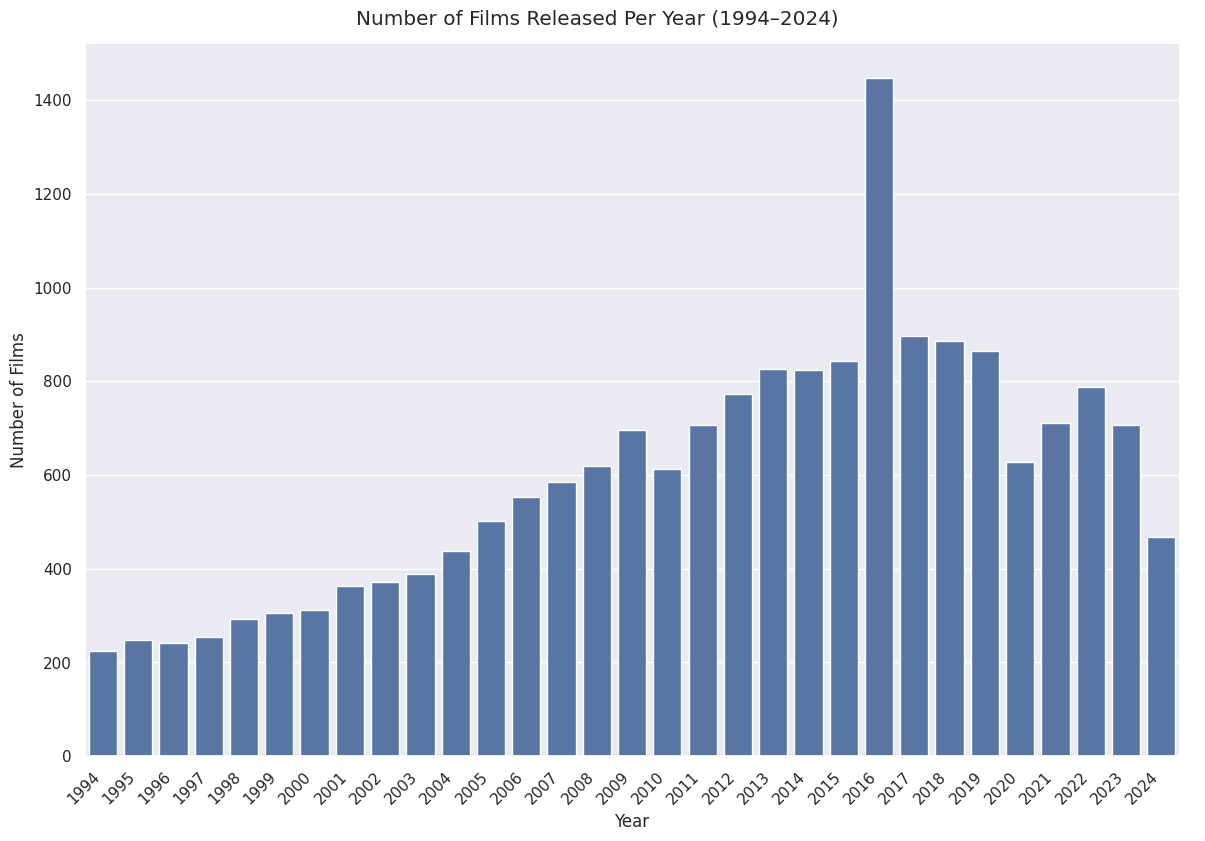

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file into a Pandas DataFrame
periods = pd.read_csv('films_per_year.csv')

# Apply the default theme for Seaborn
sns.set()

# Create a bar chart showing the number of films released each year
my_plot = sns.catplot(
    x="year",              # Year on the horizontal axis
    y="number of films",   # Number of films on the vertical axis
    kind="bar",            # A bar chart
    data=periods,          # The DataFrame containing the data
    height=8,              # Control the height of the plot
    aspect=1.5,            # Control the width-to-height ratio
)

# Add labels and a title
my_plot.set_axis_labels("Year", "Number of Films")
my_plot.fig.suptitle("Number of Films Released Per Year (1994–2024)", y=1.02)

# Rotate the year labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees, align to the right

# Show the plot
plt.show()

Downloading the picture

In [ ]:
my_plot.savefig("distribution.png")

*italicised text*## **2nd research question**



```
# Which countries have the highest and lowest numbers of women directors in feature films?
```



### Loading Wikidata !!!!

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
import requests

# GitHub raw URL for the .nq file
github_raw_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"

# Download the nquads file from GitHub
nquads_file = "wikidata_graph.nq"
response = requests.get(github_raw_url)

if response.status_code == 200:
    with open(nquads_file, 'wb') as file:
        file.write(response.content)
    print(f"File {nquads_file} downloaded successfully.")
else:
    print(f"Failed to download file: {response.status_code}")
    response.raise_for_status()

# Load the graph
g = ConjunctiveGraph()
try:
    g.parse(nquads_file, format="nquads")
    print("Graph loaded successfully.")
except Exception as e:
    print(f"Error loading graph: {e}")

# Now you can query the graph


File wikidata_graph.nq downloaded successfully.


<ipython-input-4-e3199e6d6828>:21: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = ConjunctiveGraph()


Graph loaded successfully.


### Filter and Mine


In [ ]:
from rdflib.plugins.sparql import prepareQuery

import csv

# Prepare the SPARQL query
query = prepareQuery("""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?countryLabel (COUNT(DISTINCT ?director) AS ?director_count)
WHERE {
  # Instance of film
  ?film wdt:P31 wd:Q11424 .

  # Directed by a director
  ?film wdt:P57 ?director .

  # Country of origin
  ?film wdt:P19 ?country .
  ?country rdfs:label ?countryLabel . # Get country label
  FILTER(LANG(?countryLabel) = "en") # English label
  FILTER(?countryLabel != "Unknown Country") # Exclude Unknown Country
}
GROUP BY ?countryLabel
ORDER BY DESC(?director_count)
""")

# Execute the query
results = g.query(query)

# Prepare the CSV file
with open('directors_per_country.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)

    # Write the header row
    writer.writerow(['Country', 'Number of Women Directors'])

    # Print and write the results to the CSV file
    print("Country\tNumber of Women Directors")
    for row in results:
        # Extract row values
        country_label = row['countryLabel']  # Access by variable name
        director_count = row['director_count']  # Access by variable name

        # Print to console
        print(f"{country_label}\t{director_count}")

        # Write to CSV
        writer.writerow([country_label, director_count])

print("Data has been successfully written to 'directors_per_country.csv'.")





Country	Number of Women Directors
Unknown Country	4552
United States of America	833
Germany	630
France	424
Canada	249
Spain	227
United Kingdom	174
Italy	171
India	143
Sweden	126
Russia	118
Switzerland	107
Israel	103
Japan	101
Brazil	99
Poland	96
Argentina	91
Denmark	85
South Korea	75
Netherlands	74
People's Republic of China	71
Czech Republic	70
Austria	70
Australia	68
Iran	68
Finland	57
Turkey	55
Mexico	54
Norway	50
Hungary	48
Belgium	47
Ukraine	46
Portugal	40
Indonesia	38
Peru	37
New Zealand	33
Bulgaria	30
Nigeria	29
Lebanon	29
Serbia	28
Romania	27
Colombia	26
Bosnia and Herzegovina	25
Morocco	24
Chile	20
Taiwan	19
Pakistan	18
State of Palestine	18
Kenya	18
Bangladesh	18
Georgia	17
Greece	17
Estonia	17
Croatia	17
Jordan	16
Venezuela	16
Slovakia	15
Egypt	15
South Africa	15
Mandatory Palestine	15
Uruguay	15
Ireland	15
Kingdom of Denmark	14
Ayyubid dynasty	13
Hasmonean dynasty	13
Occupied Enemy Territory Administration	13
Roman Palestine	13
early Islamic period in Palestine	13
Kingdom o

In [ ]:
query = prepareQuery("""
SELECT ?film ?country
WHERE {
  ?film <http://www.wikidata.org/country/> ?country .
}
""")

### Pandas

In [ ]:
import pandas as pd

# Parse the CSV into a DataFrame
df = pd.read_csv("directors_per_country.csv")

# Exclude rows where the Country column is "Unknown Country"
df_filtered = df[df['Country'] != "Unknown Country"]

# Print the first 15 rows of the filtered DataFrame
print(df_filtered.head(15))


                     Country  Number of Women Directors
1   United States of America                        833
2                    Germany                        630
3                     France                        424
4                     Canada                        249
5                      Spain                        227
6             United Kingdom                        174
7                      Italy                        171
8                      India                        143
9                     Sweden                        126
10                    Russia                        118
11               Switzerland                        107
12                    Israel                        103
13                     Japan                        101
14                    Brazil                         99
15                    Poland                         96


In [ ]:
!pip install plotly

In [ ]:
import plotly.express as px

# Create a choropleth map
fig = px.choropleth(
    df_filtered,
    locations="Country",  # Column with country names
    locationmode="country names",  # Use country names to map locations
    color="Number of Women Directors",  # Column to color by
    title="Number of Women Directors by Country",
    color_continuous_scale="Blues"
)

# Show the map
fig.show()


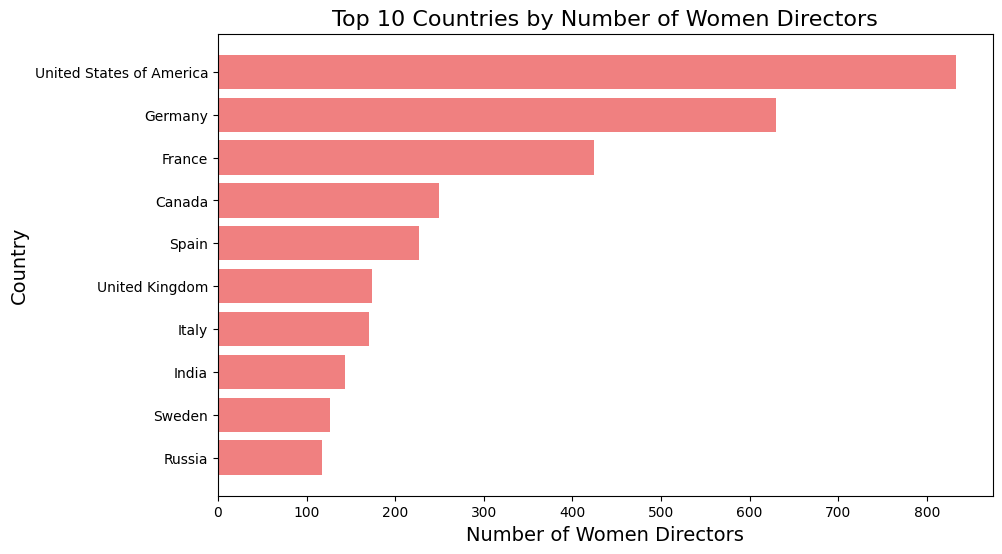

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("directors_per_country.csv")

# Exclude "Unknown Country"
df_filtered = df[df['Country'] != "Unknown Country"]

# Sort the filtered data by the number of directors
df_sorted = df_filtered.sort_values(by='Number of Women Directors', ascending=False)

# Select top 10 countries
df_top10 = df_sorted.head(10)

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(df_top10['Country'], df_top10['Number of Women Directors'], color='lightcoral')

# Add titles and labels
plt.title("Top 10 Countries by Number of Women Directors", fontsize=16)
plt.xlabel("Number of Women Directors", fontsize=14)
plt.ylabel("Country", fontsize=14)

# Invert y-axis for better readability
plt.gca().invert_yaxis()

# Show the plot
plt.show()


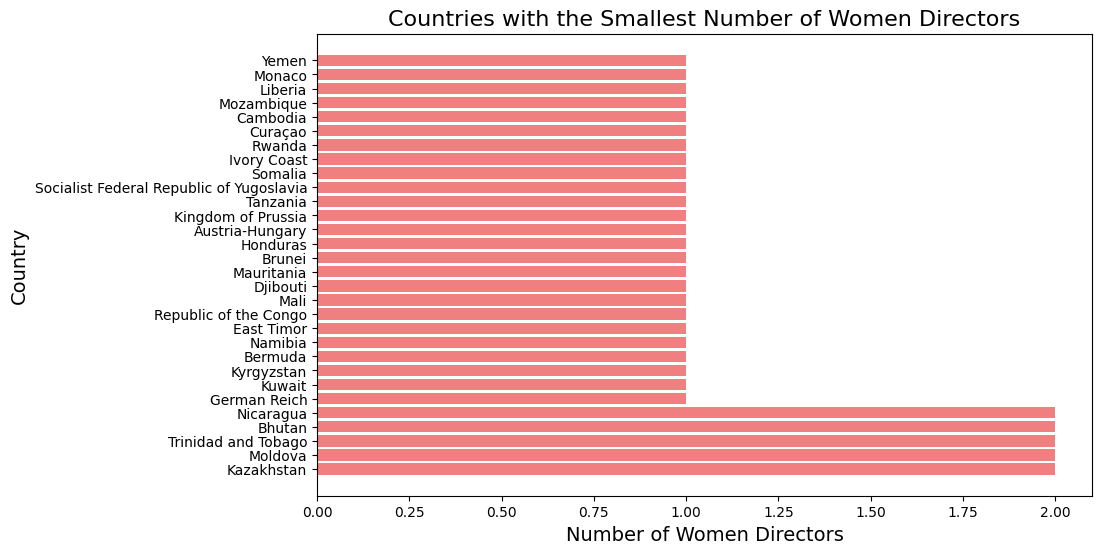

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("directors_per_country.csv")

# Exclude "Unknown Country"
df_filtered = df[df['Country'] != "Unknown Country"]

# Sort the data by the number of directors in ascending order
df_sorted = df_filtered.sort_values(by='Number of Women Directors', ascending=True)

# Select the countries with the smallest number of directors
df_smallest = df_sorted.head(30)

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(df_smallest['Country'], df_smallest['Number of Women Directors'], color='lightcoral')

# Add titles and labels
plt.title("Countries with the Smallest Number of Women Directors", fontsize=16)
plt.xlabel("Number of Women Directors", fontsize=14)
plt.ylabel("Country", fontsize=14)

# Invert y-axis for better readability
plt.gca().invert_yaxis()

# Show the plot
plt.show()


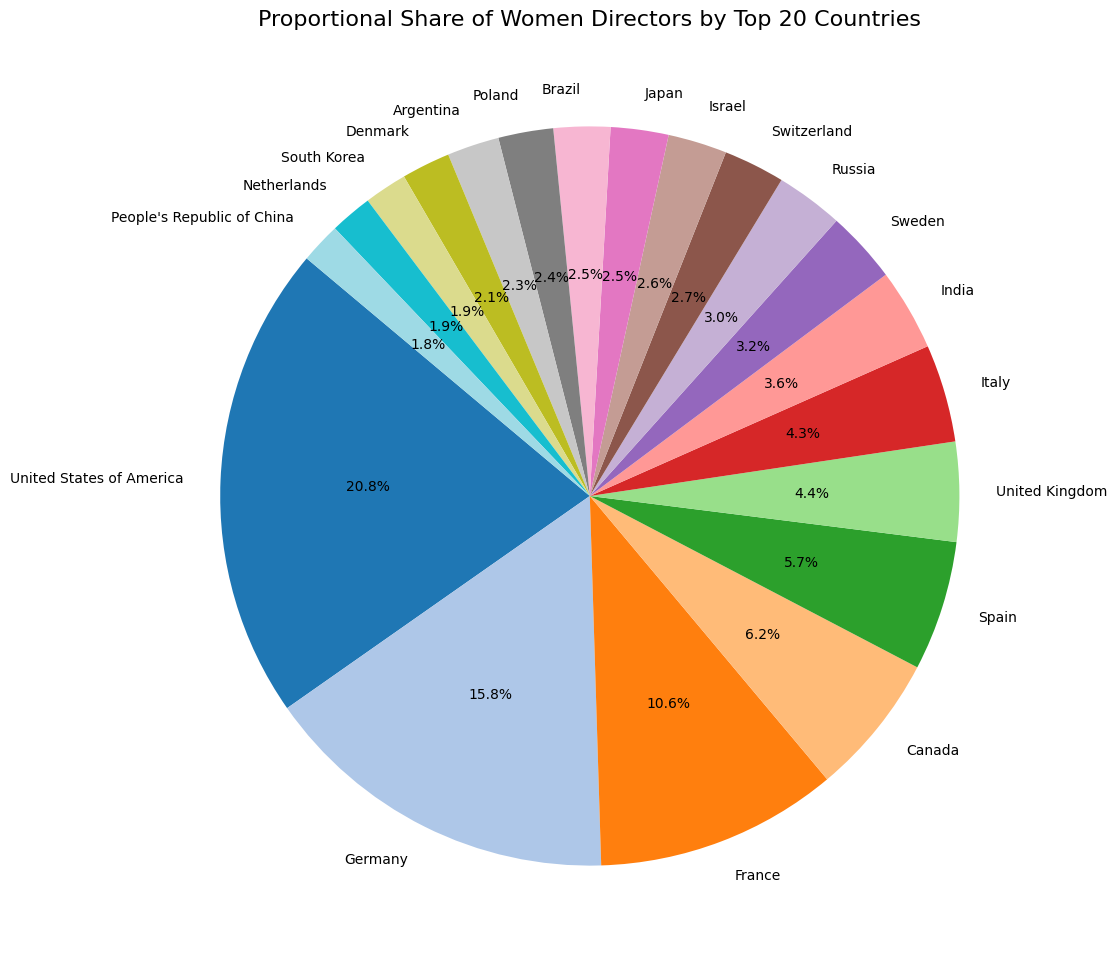

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("directors_per_country.csv")

# Exclude "Unknown Country"
df_filtered = df[df['Country'] != "Unknown Country"]

# Sort the data by the number of directors in descending order
df_sorted = df_filtered.sort_values(by='Number of Women Directors', ascending=False)

# Select the top 20 countries
df_top20 = df_sorted.head(20)

# Create a pie chart for the top 20 countries
plt.figure(figsize=(12, 12))
plt.pie(
    df_top20['Number of Women Directors'],
    labels=df_top20['Country'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Proportional Share of Women Directors by Top 20 Countries", fontsize=16)
plt.show()


### 3d Research question

What is the relationship between independent cinema and the rise of women directors in feature films?

In [ ]:
print("Year\tGenre\tNumber of Women Directors")

for year in range(1994, 2025):
    # Construct the query dynamically for each year
    query = f"""
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?genreLabel (COUNT(DISTINCT ?director) AS ?director_count)
    WHERE {{
      # Instance of film
      ?film wdt:P31 wd:Q11424 .

      # Directed by a director
      ?film wdt:P57 ?director .

      # Release year matches the current year
      ?film wdt:P577 "{year}"^^<http://www.w3.org/2000/01/rdf-schema#Literal> .

      # Genre classification
      ?film wdt:P136 ?genre .
      ?genre rdfs:label ?genreLabel .

      # Focus on independent cinema and other genres
      FILTER(LANG(?genreLabel) = "en")
    }}
    GROUP BY ?genreLabel
    ORDER BY DESC(?director_count)
    """

    # Execute the query
    results = g.query(query)

    # Print the results for the current year
    for row in results:
        print(f"{year}\t{row['genreLabel']}\t{row['director_count']}")



Year	Genre	Number of Women Directors
1994	drama film	79
1994	documentary film	45
1994	Unknown Genre	35
1994	comedy film	25
1994	comedy drama	13
1994	LGBT-related film	11
1994	romance film	9
1994	children's film	6
1994	biographical film	6
1994	action film	5
1994	thriller film	5
1994	film based on a novel	4
1994	fantasy film	4
1994	erotic film	4
1994	romantic comedy	4
1994	experimental film	4
1994	horror film	4
1994	compilation film	3
1994	teen film	3
1994	Christmas film	2
1994	adventure film	2
1994	crime film	2
1994	buddy film	1
1994	coming-of-age fiction	1
1994	vampire film	1
1994	road movie	1
1994	ghost film	1
1994	science fiction film	1
1994	cyberpunk	1
1994	erotic thriller	1
1994	dance film	1
1994	video art	1
1994	romantic drama	1
1994	animated film	1
1994	queer film	1
1994	parable	1
1994	cinematic fairy tale	1
1994	silent film	1
1994	crossover fiction	1
1994	comedy horror	1
1994	prison film	1
1994	concert film	1
1994	family film	1
1994	fiction film	1
1994	historical film	1
1994	ind

In [37]:
print("Year\tMost Popular Genre\tNumber of Films")

for year in range(1994, 2025):
    # Construct the query dynamically for each year
    query = f"""
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?genreLabel (COUNT(DISTINCT ?film) AS ?film_count)
    WHERE {{
      # Instance of film
      ?film wdt:P31 wd:Q11424 .

      # Directed by a director
      ?film wdt:P57 ?director .

      # Release year matches the current year
      ?film wdt:P577 "{year}"^^<http://www.w3.org/2000/01/rdf-schema#Literal> .

      # Genre classification
      ?film wdt:P136 ?genre .
      ?genre rdfs:label ?genreLabel .

      # Filter for English language labels
      FILTER(LANG(?genreLabel) = "en")
    }}
    GROUP BY ?genreLabel
    ORDER BY DESC(?film_count)
    LIMIT 1
    """

    # Execute the query
    results = g.query(query)

    # Print the result for the current year
    for row in results:
        print(f"{year}\t{row['genreLabel']}\t{row['film_count']}")

Year	Most Popular Genre	Number of Films
1994	drama film	77
1995	documentary film	64
1996	drama film	94
1997	drama film	79
1998	drama film	96
1999	drama film	93
2000	drama film	99
2001	drama film	137
2002	drama film	138
2003	drama film	128
2004	drama film	155
2005	documentary film	163
2006	drama film	171
2007	drama film	206
2008	drama film	196
2009	drama film	222
2010	drama film	203
2011	drama film	244
2012	drama film	245
2013	documentary film	264
2014	documentary film	254
2015	drama film	272
2016	documentary film	845
2017	drama film	306
2018	drama film	315
2019	drama film	317
2020	drama film	217
2021	documentary film	270
2022	drama film	275
2023	drama film	232
2024	drama film	120
